# Scattering matrix plugin

Note: the cost of running the entire notebook is larger than 1 FlexUnit.

This notebook will give a demo of the tidy3d [ComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc1/_autosummary/tidy3d.plugins.ComponentModeler.html) plugin used to compute scattering matrix elements.

In [1]:
# make sure notebook plots inline
%matplotlib inline
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gdstk

# tidy3D imports
import tidy3d as td
from tidy3d import web

# set tidy3d to only print error information to reduce verbosity
td.config.logging_level = "error"

[23:05:24] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=542209;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=180456;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#103\103]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.9.0rc1                                                  ]8;id=400427;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=192818;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#121\121]8;;\

## Setup

We will simulate a directional coupler, similar to the GDS and Parameter scan tutorials.

Let's start by setting up some basic parameters.

In [2]:
# wavelength / frequency
lambda0 = 1.550  # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Spatial grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=14, wavelength=lambda0)

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 1.0
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# length of coupling region (um)
coup_length = 6.0
# spacing between waveguides in coupling region (um)
wg_spacing_coup = 0.05
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# Straight waveguide sections on each side
straight_wg_length = 4
# space between waveguide and PML
pml_spacing = 2

### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def tanh_interp(max_arg):
    """Interpolator for tanh with adjustable extension"""
    scale = 1 / np.tanh(max_arg)
    return lambda u: 0.5 * (1 + scale * np.tanh(max_arg * (u * 2 - 1)))

def make_coupler(
    length, wg_spacing_in, wg_width, wg_spacing_coup, coup_length, bend_length, npts_bend=30
):
    """Make an integrated coupler using the gdstk RobustPath object."""
    # bend interpolator
    interp = tanh_interp(3)
    delta = wg_width + wg_spacing_coup - wg_spacing_in
    offset = lambda u: wg_spacing_in + interp(u) * delta

    coup = gdstk.RobustPath(
        (-0.5 * length, 0),
        (wg_width, wg_width),
        wg_spacing_in,
        simple_path=True,
        layer=1,
        datatype=[0, 1],
    )
    coup.segment((-0.5 * coup_length - bend_length, 0))
    coup.segment(
        (-0.5 * coup_length, 0), offset=[lambda u: -0.5 * offset(u), lambda u: 0.5 * offset(u)]
    )
    coup.segment((0.5 * coup_length, 0))
    coup.segment(
        (0.5 * coup_length + bend_length, 0),
        offset=[lambda u: -0.5 * offset(1 - u), lambda u: 0.5 * offset(1 - u)],
    )
    coup.segment((0.5 * length, 0))
    return coup

### Create Base Simulation

The scattering matrix tool requires the "base" [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc1/_autosummary/tidy3d.Simulation.html) (without the modal sources or monitors used to compute S-parameters), so we will construct that now.

We generate the structures and add a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc1/_autosummary/tidy3d.FieldMonitor.html?highlight=FieldMonitor) so we can inspect the field patterns.

In [4]:
# Geometry must be placed in GDS cells to import into Tidy3D
coup_cell = gdstk.Cell("Coupler")

substrate = gdstk.rectangle(
    (-device_length / 2, -wg_spacing_in / 2 - 10),
    (device_length / 2, wg_spacing_in / 2 + 10),
    layer=0,
)
coup_cell.add(substrate)

# Add the coupler to a gdspy cell
gds_coup = make_coupler(
    device_length, wg_spacing_in, wg_width, wg_spacing_coup, coup_length, bend_length
)
coup_cell.add(gds_coup)

# Substrate
oxide_geo, = td.PolySlab.from_gds(
    gds_cell=coup_cell, gds_layer=0, gds_dtype=0, slab_bounds=(-10, 0), axis=2
)

oxide = td.Structure(geometry=oxide_geo, medium=mat_sub)

# Waveguides (import all datatypes if gds_dtype not specified)
coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
    gds_cell=coup_cell, gds_layer=1, slab_bounds=(0, wg_height), axis=2
)

coupler1 = td.Structure(geometry=coupler1_geo, medium=mat_wg)

coupler2 = td.Structure(geometry=coupler2_geo, medium=mat_wg)

# Simulation size along propagation direction
sim_length = 2 * straight_wg_length + 2 * bend_length + coup_length

# Spacing between waveguides and PML
sim_size = [
    sim_length,
    wg_spacing_in + wg_width + 2 * pml_spacing,
    wg_height + 2 * pml_spacing,
]

# source
src_pos = sim_length / 2 - straight_wg_length / 2

# in-plane field monitor (optional, increases required data storage)
domain_monitor = td.FieldMonitor(
    center=[0, 0, wg_height / 2], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

# initialize the simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[oxide, coupler1, coupler2],
    sources=[],
    monitors=[domain_monitor],
    run_time=50 / fwidth,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

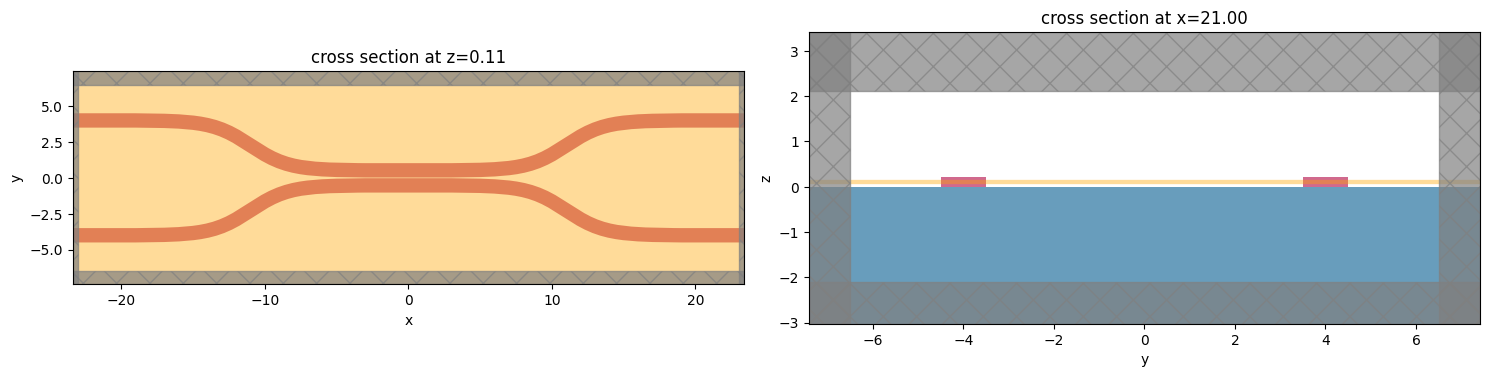

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = sim.plot(z=wg_height / 2, ax=ax1)
ax2 = sim.plot(x=src_pos, ax=ax2)

## Setting up Scattering Matrix Tool
Now, to use the S matrix tool, we need to defing the spatial extent of the "ports" of our system using [Port](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc1/_autosummary/tidy3d.plugins.Port.html) objects.

These ports will be converted into modal sources and monitors later, so they require both some mode specification and a definition of the direction that points into the system.

We'll also give them names to refer to later.

In [6]:
from tidy3d.plugins.smatrix.smatrix import Port

num_modes = 1

port_right_top = Port(
    center=[src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="-",
    name="right_top",
)

port_right_bot = Port(
    center=[src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="-",
    name="right_bot",
)

port_left_top = Port(
    center=[-src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="+",
    name="left_top",
)

port_left_bot = Port(
    center=[-src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="+",
    name="left_bot",
)

ports = [port_right_top, port_right_bot, port_left_top, port_left_bot]

Next, we will add the base simulation and ports to the [ComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc1/_autosummary/tidy3d.plugins.ComponentModeler.html), along with the frequency of interest and a name for saving the batch of simulations that will get created later.

In [7]:
from tidy3d.plugins.smatrix.smatrix import ComponentModeler

modeler = ComponentModeler(simulation=sim, ports=ports, freq=freq0)

Output()

Output()

Output()

Output()

We can plot the simulation with all of the ports as sources to check things are set up correctly.

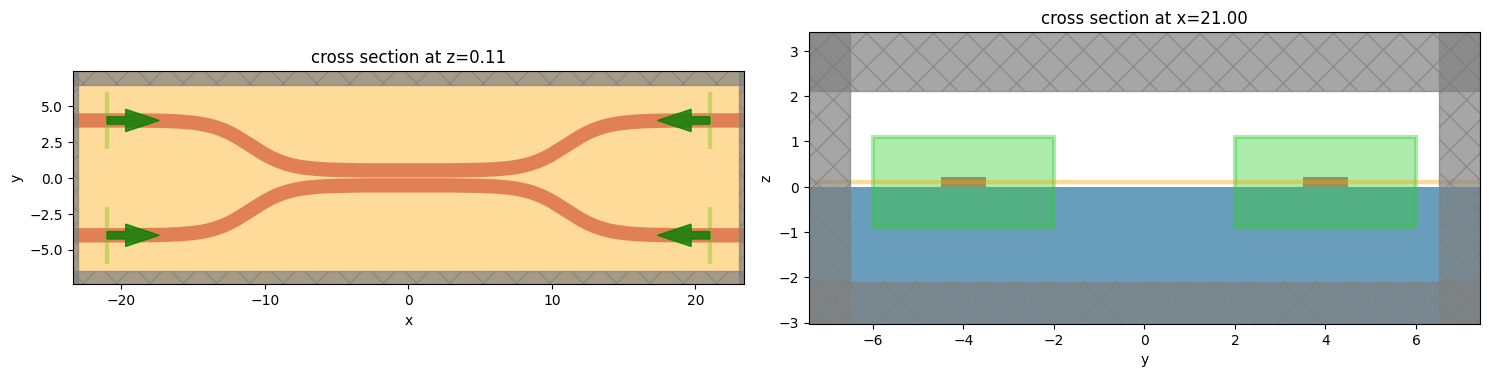

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = modeler.plot_sim(z=wg_height / 2, ax=ax1)
ax2 = modeler.plot_sim(x=src_pos, ax=ax2)

## Solving for the S matrix

With the component modeler defined, we may call it's `.solve()` method to run a batch of simulations to compute the S matrix.
The tool will loop through each port and create one simulation per mode index (as defined by the mode specifications) where a unique modal source is injected.
Each of the ports will also be converted to mode monitors to measure the mode amplitudes and normalization.

In [9]:
smatrix = modeler.run(path_dir="data")

[23:05:34] Started working on Batch.                                                               ]8;id=685853;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=759636;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#361\361]8;;\

Output()

[23:08:59] Batch complete.                                                                         ]8;id=616230;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=234580;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#382\382]8;;\

Output()

Output()

Output()

Output()

## Working with Scattering Matrix

The scattering matrix returned by the solve is actually a nested dictionarty relating the port names and mode_indices.
For example `smatrix[(name1, mode_index1)][(name2, mode_index_2)]` gives the complex scattering matrix element.

For example:

In [10]:
smatrix[("left_top", 0)][("right_bot", 0)]

(0.05434682063201947+0.09051219845214702j)

Alternatively, we can convert this into a numpy array:

In [11]:
port_names = list(smatrix.keys())
S = np.array([[smatrix[p_out][p_in] for p_in in port_names] for p_out in port_names])
print(S.shape)

(4, 4)


We can inspect `S` and note that the diagonal elements are very small indicating low backscattering.

Summing each rows of the matrix should give 1.0 if no power was lost.

In [12]:
np.sum(abs(S) ** 2, axis=0)

array([0.99702704, 0.99702684, 0.99702037, 0.99702007])

Finally, we can check whether `S` is close to unitary as expected.

S times it's Hermitian conjugate should be the identy matrix.

In [13]:
mat = S @ (np.conj(S.T))

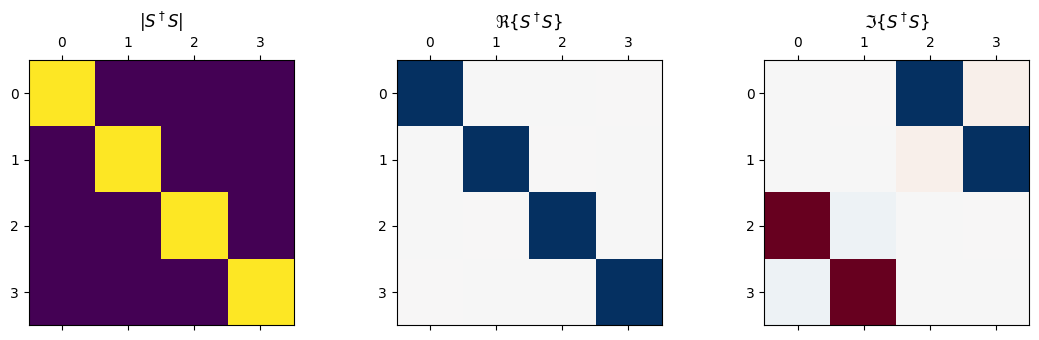

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3.5))
imabs = ax1.matshow(abs(mat))
vmax = np.abs(mat.real).max()
imreal = ax2.matshow(mat.real, cmap="RdBu", vmin=-vmax, vmax=vmax)
vmax = np.abs(mat.imag).max()
imimag = ax3.matshow(mat.imag, cmap="RdBu", vmin=-vmax, vmax=vmax)
ax1.set_title("$|S^\dagger S|$")
ax2.set_title("$\Re\{S^\dagger S\}$")
ax3.set_title("$\Im\{S^\dagger S\}$")
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

It looks pretty close, but there seems to indeed be a bit of loss (expected).

## Viewing individual Simulation Data
To verify, we may want to take a look the individual simulation data.
For that, we can load up the batch and inspect the [SimulationData](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc1/_autosummary/tidy3d.Simulation.html) for each task.

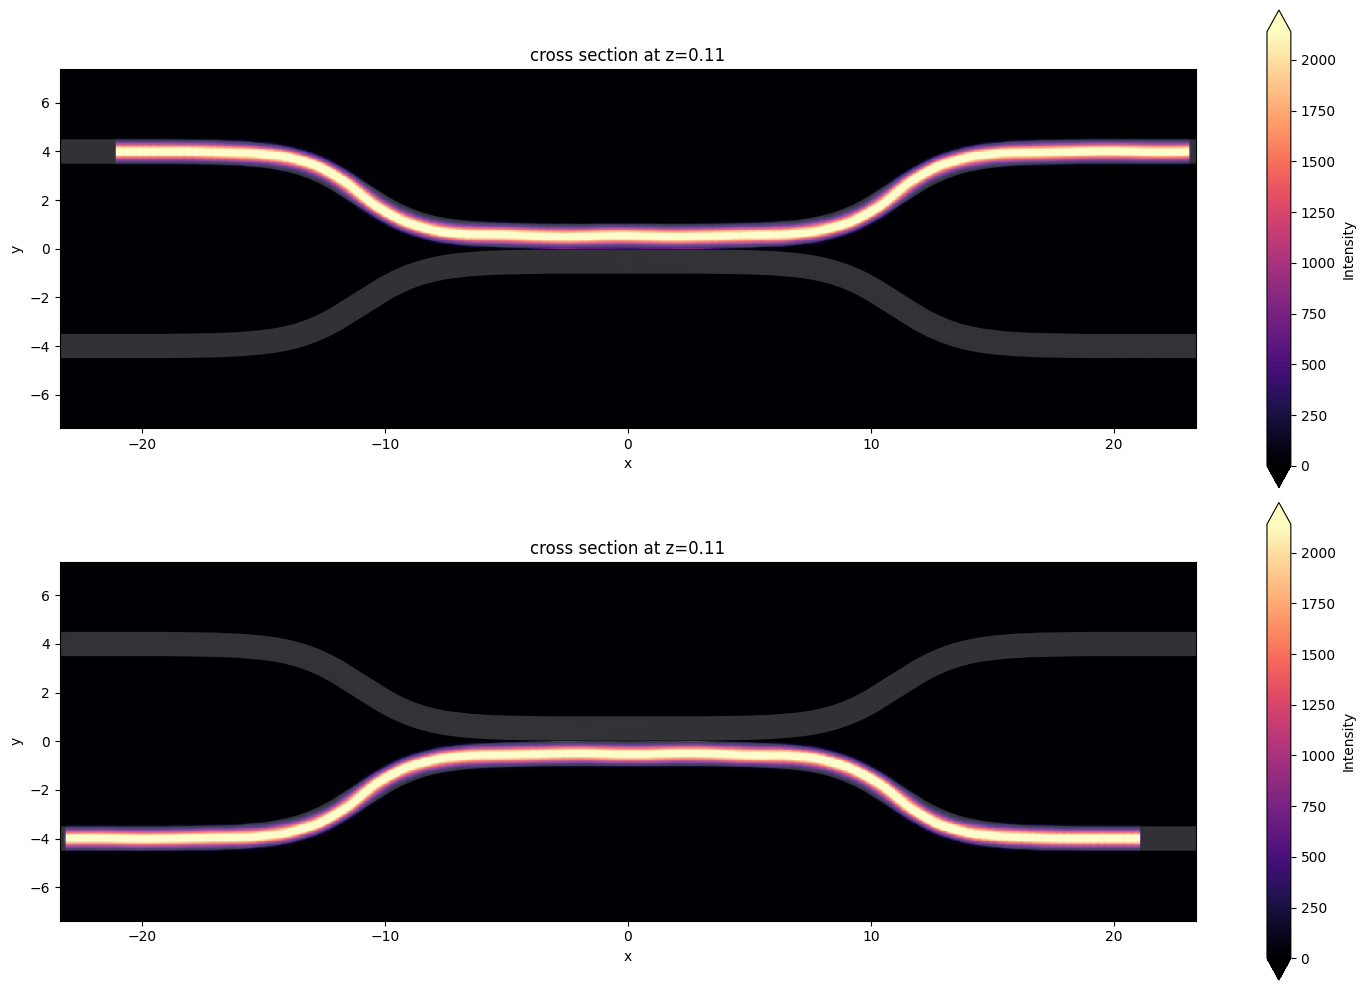

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = modeler.batch.load(path_dir="data")["smatrix_left_top_0"].plot_field(
    "field", "int", z=wg_height / 2, ax=ax1
)
ax2 = modeler.batch.load(path_dir="data")["smatrix_right_bot_0"].plot_field(
    "field", "int", z=wg_height / 2, ax=ax2
)

## Saving and Loading Results

Finally, we can save and load the component modeler from file to save the results.

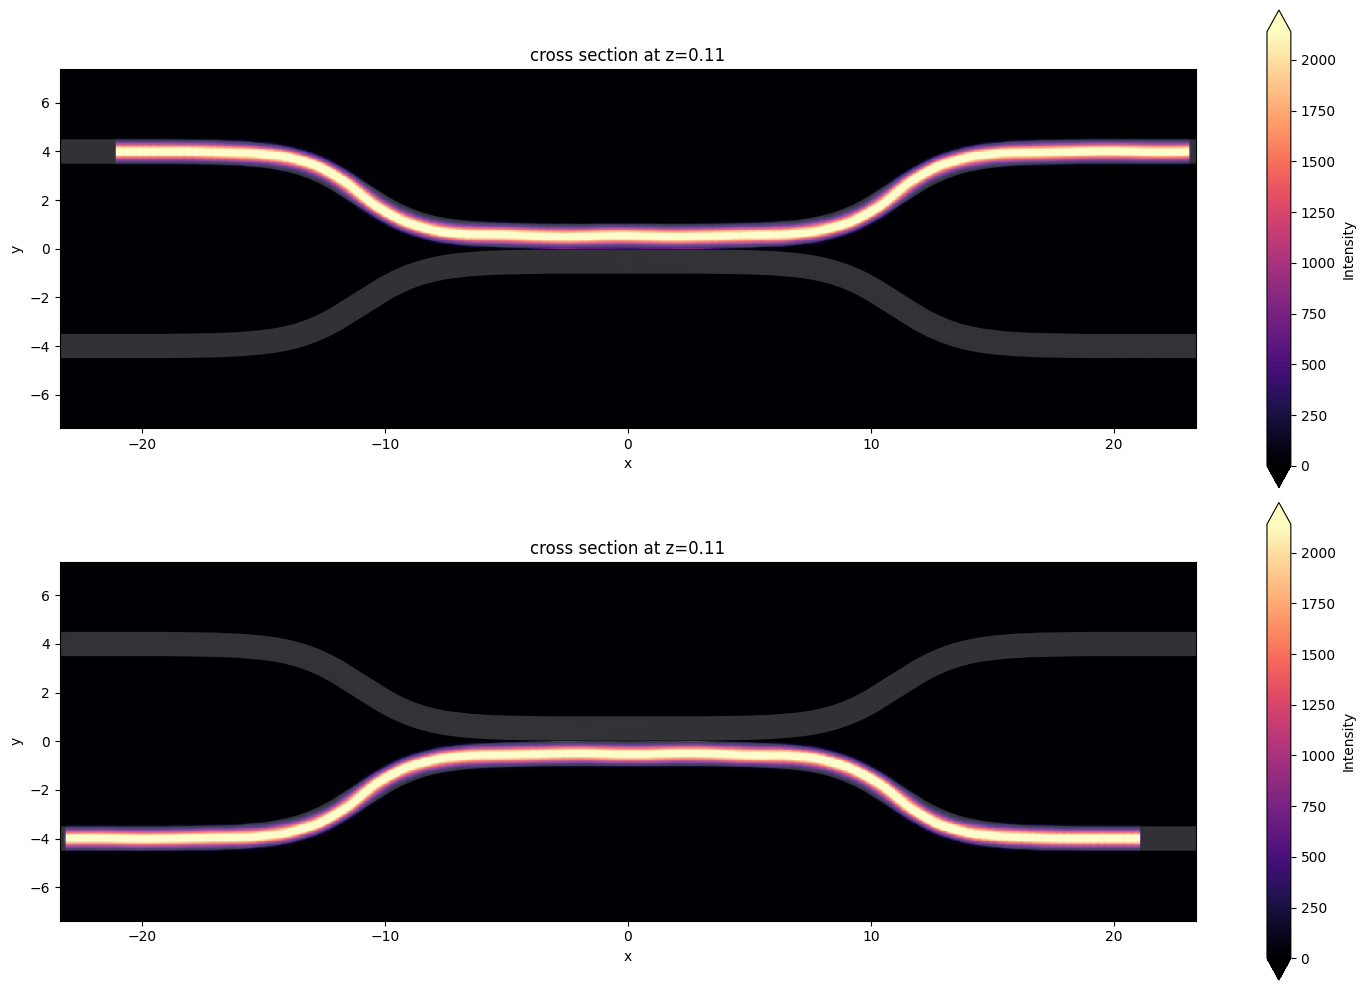

In [16]:
fname = "data/modeler.json"
modeler.to_file(fname)
modeler2 = ComponentModeler.from_file(fname)
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = modeler2.batch.load(path_dir="data")["smatrix_left_top_0"].plot_field(
    "field", "int", z=wg_height / 2, ax=ax1
)
ax2 = modeler2.batch.load(path_dir="data")["smatrix_right_bot_0"].plot_field(
    "field", "int", z=wg_height / 2, ax=ax2
)

## Element Mappings

If we wish, we can specify mappings between scattering matrix elements that we want to be equal up to a multiplicative factor.
We can define these as `element_mappings` in the `ComponentModeler`.

As an example, let's define this element mapping from the example above to enforce that the coupling between bottom left to bottom right should be equal to the coupling between top left to top right.

In [17]:
# these are the "indices" in our scattering matrix
left_top = ("left_top", 0)
right_top = ("right_top", 0)
left_bot = ("left_bot", 0)
right_bot = ("right_bot", 0)

# we define the scattering matrix elements coupling the top ports and bottom ports as pairs of these indices
top_coupling_l2r = (left_top, right_top)
bot_coupling_l2r = (left_bot, right_bot)
top_coupling_r2l = (right_top, left_top)
bot_coupling_r2l = (right_bot, left_bot)

# map the top coupling to the bottom coupling with a multiplicative factor of +1
map_horizontal_l2r = (top_coupling_l2r, bot_coupling_l2r, +1)
map_horizontal_r2l = (top_coupling_r2l, bot_coupling_r2l, +1)

element_mappings = (map_horizontal_l2r, map_horizontal_r2l)

In [18]:
# run the component modeler again
modeler = ComponentModeler(
    simulation=sim, ports=ports, freq=freq0, element_mappings=element_mappings
)
smatrix = modeler.run()

Output()

Output()

Output()

Output()

[23:09:35] Started working on Batch.                                                               ]8;id=566791;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=660093;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#361\361]8;;\

Output()

[23:13:03] Batch complete.                                                                         ]8;id=691875;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=245286;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#382\382]8;;\

Output()

Output()

Output()

Output()

The resulting scattering matrix will have the element mappings applied, we can check this explicitly.

In [19]:
# assert that the horizontal couping elements are exactly equal
print(smatrix[left_top][right_top])
print(smatrix[left_bot][right_bot])

assert smatrix[left_top][right_top] == smatrix[left_bot][right_bot]

## Incomplete Scattering Matrix
Finally, to exclude some rows of the scattering matrix, one can supply a `run_only` paramteter to the `ComponentModeler`.

`run_only` contains the scattering matrix indices that the user wants to run as a source. If any indices are excluded, they will not be run.

For example, if one wants to compute scattering matrix elements from only the ports on the left hand side, the `run_only` could be defined as follows.

In [20]:
run_only = (left_top, left_bot)
modeler = ComponentModeler(simulation=sim, ports=ports, freq=freq0, run_only=run_only)
smatrix = modeler.run()

Output()

Output()

[23:26:16] Started working on Batch.                                                               ]8;id=896312;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=934276;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#361\361]8;;\

Output()

[23:28:03] Batch complete.                                                                         ]8;id=341519;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=910568;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#382\382]8;;\

Output()

Output()

The resulting scattering matrix will have the indices not included in `run_only` omitted from the keys of the outer dictionary.

In [21]:
print(left_top in smatrix)
print(right_top in smatrix)

True
False
